<a href="https://colab.research.google.com/github/juanosalvador/database-Reingreso-Hospitalario/blob/main/Clasificadores_casi_completo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# <center><h1> Modelo de Predicción: Reingreso Hospitalario</center></h1>
---

Un reingreso hospitalario es un episodio cuando un paciente que había sido dado de alta de un hospital es admitido de nuevo dentro de un intervalo de tiempo especificado. Las tasas de readmisión se han utilizado cada vez más como medida de resultado en la **investigación de servicios de salud y como referencia de calidad para los sistemas de salud**. La idea de este proyecto es predecir si un paciente con diabetes va a ser
readmitido a un hospital en función de 127 atributos (edad, sexo, tiempo en el hospital,
medicamentos, etc.)

---

<center><h1> Descripción del Set de Datos</h1></center>

El conjunto de datos representa 10 años de (1999-2008) de atención clínica en 130 hospitales y redes integradas de prestación de servicios de EE.UU.  Incluye más de 50 funciones que representan los resultados del paciente y del hospital.
Se extrajo información de la base de datos para los encuentros que 
cumplieron con los siguientes criterios.

* Es un encuentro hospitalario (una admisión hospitalaria).
*  Es un encuentro diabético, es decir, durante el cual se ingresó al sistema cualquier tipo de diabetes como diagnóstico.
* La duración de la estancia fue de al menos 1 día y como máximo 14 días.
*  Se realizaron pruebas de laboratorio durante el encuentro.
* Se administraron medicamentos durante el encuentro.

Los datos contienen atributos tales como número de paciente, raza, sexo, edad, tipo de admisión, tiempo en el hospital, especialidad médica del médico que lo admite, número de pruebas de laboratorio realizadas, resultado de la prueba de HbA1c, diagnóstico, cantidad de medicación, medicamentos para diabéticos, cantidad de pacientes ambulatorios , visitas hospitalarias y urgentes en el año anterior a la hospitalización, etc.

En general, la bd cuenta con 50 atributos con la información anteriormente señalada, y un total de 101766 registros. La base de datos buscar predecir la readmisión de un paciente, esta variable esta compuesta de dos valores: 
* Readmisión del paciente dentro de los 30 días posteriores al alta.
* Readmisión del paciente despues de los 30 días posteriores al alta, que también engloba la no readmisión.


Datos: http://bit.ly/1aZzTmO
---

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
url = 'https://raw.githubusercontent.com/juanosalvador/database-Reingreso-Hospitalario/main/diabetic_data.csv'

# <center><h1> 1. Exploración y Limpieza de datos </h1></center>

---

In [ ]:
df = pd.read_csv(url)

In [ ]:
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,?,?,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,59,0,18,0,0,0,276,250.01,255,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,11,5,13,2,0,1,648,250,V27,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,44,1,16,0,0,0,8,250.43,403,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,51,0,8,0,0,0,197,157,250,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO


La base de datos cuenta con un total de 50 atributos. La gran mayoría de las variables son no métricas del tipo nominal. También se registran variables métricas, específicamente discretas o cuantitativas discretas, no se regsitraron variables cuantitativas continuas.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

La BD contiene un total de 101766 registros, de los cuales hay pacientes duplicados debido a que ya han reingresado con anterioridad. Estos registros serán eliminados, solo se conservará el primer ingreso registrado para cada paciente, esto evitará sesgar los resultados hacia los pacientes que tienen multiples encuentros. Por lo tanto, la base de datos queda con un total de 71518 registros y 50 columnas.

In [ ]:
df = df.drop_duplicates(subset= ['patient_nbr'], keep = 'first')

In [ ]:
df.shape

(71518, 50)

# 1.1 Detección de valores faltantes.

En la BD, los datos faltantes están representados con un signo de interrogación "?", para el atributo "gender" los datos faltantes están representados como "Unknow/Invalid". Estos registros serán reemplazados por "nan".

In [ ]:
## reemplazando por faltantes
df = df.replace('Unknown/Invalid', np.nan)
df = df.replace('?',np.nan)

In [ ]:
## Columnas con valores faltantes
print('Columnas con valores faltantes:')
print('')
for col in df.columns:
  if df[col].isnull().sum() >0 :
    faltantes = round(df[col].isnull().sum()*100 / len(df), 3)
    print(col,'-->',str(faltantes) + ' %')

Columnas con valores faltantes:

race --> 2.724 %
gender --> 0.004 %
weight --> 96.011 %
payer_code --> 43.406 %
medical_specialty --> 48.207 %
diag_1 --> 0.015 %
diag_2 --> 0.411 %
diag_3 --> 1.713 %


# 1.2 Tratamiento de valores Faltantes

* Race: Solo tiene un 2.724% de valores faltantes por lo cual estos registros serán eliminados.

* Gender: Solo tiene un 0.004% de faltantes, estos registros serán eliminados.

* Weight: Tiene un total de 96.011%, tratar esta columnas e inviable por lo tanto será eliminada

* Payer Code: Con un total de 43.406%. Se completarán los faltantes con "No value".

* Medical especialty: Con un total de 48.2% de datos faltantes. Se completarán los faltantes con "No value".

* diag_1, diag_2, diag_3: De estos tres atributos solo se utilizará la columnas diag_1, de acuerdo a lo planteado en el paper.



In [ ]:
## Eliminando columnas
df = df.drop(['weight'], axis = 1)

In [ ]:
## Completando con "No value" los valores nan
df['payer_code'].fillna('No value', inplace = True)
df['medical_specialty'].fillna('No value', inplace = True)

In [ ]:
#ELiminando filas con valores faltantes
df.dropna(inplace= True)

In [ ]:
df.shape

(68357, 49)

# 1.3 Eliminando Columnas categóricas con un solo valor



In [ ]:
categoricos = df.select_dtypes(include = 'object') ## Separando datos categóricos
numericos = df.select_dtypes(exclude = 'object') # Separando datos numéricos

In [ ]:
## Identificando columnas con solo una categoría
### funcion resumen
def resume(data,col):
  tabla = data.groupby(col).size().reset_index().rename(columns={0:'Frec. Abs'}).sort_values(by=['Frec. Abs'], ascending = False).reset_index(drop=True)
  return tabla
def DetectOneCategory(categoricos):
  col_1categoria = []
  for col in categoricos:
    cat = resume(categoricos,col).shape[0]
    if cat ==1:
      col_1categoria.append(col)
      print(col, '-->', resume(categoricos,col).shape[0], 'categoría')

In [ ]:
DetectOneCategory(categoricos)

examide --> 1 categoría
citoglipton --> 1 categoría
glimepiride-pioglitazone --> 1 categoría
metformin-rosiglitazone --> 1 categoría


* La variable examide y citoglipton solo tienen una categoria, lo cual no aportan información, serán eliminadas.

* Las variables metformin-rosiglitazone y metformin-rosglitazonen no se elmiminarán ya que son indicadores que informan su se le suministro medicamentos al paciente durante la estadía hospitalaria.

In [ ]:
## Removemos el id del encuetntro y el id de paciente
df = df.drop(['encounter_id','patient_nbr'], axis = 1)

In [ ]:
df = df.drop(['examide','citoglipton'], axis = 1)

# 1.4 Eliminando registros

De la columna discharge_disposition, la cual informa a donde fue el paciente despues del alta, se eliminarán las categorías relacionadas a cuando el paciente falleció o fue alta a un hospicio (según https://www.hindawi.com/journals/bmri/2014/781670/), estos registros se eliminan ya que no se pueden readmitir.

In [ ]:
df = df.loc[~df.discharge_disposition_id.isin([11,13,14,19,20,21])]

# 2. Reducción de atributos de medicación

* Reduciendo los atributos de medicación, estos atributos indican si se subió la dosis o se bajó, si se mantubo constante o no están en tratamiento. Se le asignara un uno a up, down, steady y un 0 a No

In [ ]:
medicacion = ['metformin' ,'repaglinide','nateglinide','chlorpropamide','glimepiride','acetohexamide' ,'glipizide',\
              'glyburide', 'tolbutamide', 'pioglitazone','rosiglitazone', 'acarbose' ,'miglitol' ,'troglitazone', \
              'tolazamide', 'insulin' ,'glyburide-metformin','glipizide-metformin', \
              'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone']

In [ ]:
#asignando un valor de 0 si no están en tratamiento y asignando 1 si están tomando si dosis creciente / decreciente / constante
for i in medicacion:
    df[i] = df[i].apply(lambda x: 0 if x == "No" else 1)

In [ ]:
# Calculando el total de tratamientos tomados por el paciente
df['indicador_tratamiento'] = np.zeros((len(df['metformin'])))
for col in medicacion:
    df['indicador_tratamiento'] += df[col]

In [ ]:
# Eliminamos todas las columnas de medicacion
df = df.drop(medicacion, axis = 1)


# 3.Tratamiento columnas diag_1, diag_2, diag_3

In [ ]:
# Categorización basada de --> https://www.hindawi.com/journals/bmri/2014/781670/tab2/.Classified diagnóstico en 9 categorías
#Categorias[0-8]: Other,Circulatory, Respiratory,Digestive, Diabetes,Injury, Musculoskeletal,Genitourinary,Neoplasms
# función para clasificar los números en una de las 8 categorías
def getCategor(x):
    if 'V' in str(x) or 'E' in str(x):
        return 0
    
    x = float(x)
    
    if (x >= 390 and x <= 459) or np.floor(x) == 785:
        return 1
    elif (x >= 460 and x <= 519) or np.floor(x) == 786:
        return 2
    elif (x >= 520 and x <= 579) or np.floor(x) == 787:
        return 3
    elif np.floor(x) == 250:
        return 4
    elif x >= 800 and x <= 999:
        return 5
    elif x >= 710 and x <= 739:
        return 6
    elif (x >= 580 and x <= 629) or np.floor(x) == 788:
        return 7
    elif x >= 140 and x <= 239:
        return 8
    else:
        return 0

In [ ]:
df['categorias_diag_1'] = df['diag_1'].apply(lambda x: getCategor(x))

In [ ]:
## Eliminamos las categorias de diagnóstico que no se utilizarán
df = df.drop(['diag_1','diag_2', 'diag_3'], axis = 1)

# 3.1 Columnas con muchas categorías

In [ ]:
categoricos = df.select_dtypes(include = 'object') ## Separando datos categóricos
## Identificando columnas con mas de 10 categorias
def AlotCategory(categoricos, number_category):
  col_cat = []
  for col in categoricos:
    cant_cat = len(categoricos[col].unique())
    if cant_cat > number_category:
      print('La columna ' , col , 'tiene ',cant_cat , ' Categorías')

AlotCategory(categoricos, 20)

La columna  medical_specialty tiene  71  Categorías


In [ ]:
## La columnas medical_specialty tiene 71 categorias, se hará un top 10 con las especialidades más frecuentes y el resto se incluíran 
# la categoría "Otros"
top_10_medical_specialty = resume(df,'medical_specialty').iloc[0:10,:]['medical_specialty'].to_list()

In [ ]:
#df['medical_specialty2'] = df['medical_specialty'].copy()
# Generamos la categoría "otros"
#df.loc[~df.med_spe.isin(top_10_medical_specialty), 'med_spe'] = 'Otros'

In [ ]:
df.loc[~df.medical_specialty.isin(top_10_medical_specialty), 'medical_specialty'] = 'Otros'

In [ ]:
df.head()

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,max_glu_serum,A1Cresult,change,diabetesMed,readmitted,indicador_tratamiento,categorias_diag_1
1,Caucasian,Female,[10-20),1,1,7,3,No value,No value,59,0,18,0,0,0,9,None,None,Ch,Yes,>30,1.0,0
2,AfricanAmerican,Female,[20-30),1,1,7,2,No value,No value,11,5,13,2,0,1,6,None,None,No,Yes,NO,1.0,0
3,Caucasian,Male,[30-40),1,1,7,2,No value,No value,44,1,16,0,0,0,7,None,None,Ch,Yes,NO,1.0,0
4,Caucasian,Male,[40-50),1,1,7,1,No value,No value,51,0,8,0,0,0,5,None,None,Ch,Yes,NO,2.0,8
5,Caucasian,Male,[50-60),2,1,2,3,No value,No value,31,6,16,0,0,0,9,None,None,No,Yes,>30,1.0,1


# 4. Tratamiento variable age

In [ ]:
## Age
# funcion para establecer el valor promedio en la variable edad
def agecategory(x):
    
    if x == "[0-10)" :
        return 5
    elif x == "[10-20)":
        return 15
    elif x == "[20-30)":
        return 25
    elif x == "[30-40)":
        return 35
    elif x == "[40-50)":
        return 45
    elif x == "[50-60)":
        return 55
    elif x == "[60-70)":
        return 65
    elif x == "[70-80)":
        return 75
    else:
        return 0

In [ ]:
df['age'] = df['age'].apply(lambda x: agecategory(x))

# <center><h1> 5. Cambiando el tipo de datos de variables numéricas que en realidad son categóricas nominales. </h1></center>

In [ ]:
#cambiando el tipo de datos a las variables admission_type_id, discharge_disposition_id, admission_source_id diag_1_category, \
# max_glu_serum, A1Cresult into categorical ya que no son variables numéricas precisamente
df['admission_type_id'] = df['admission_type_id'].astype('object')
df['admission_source_id'] = df['admission_source_id'].astype('object')
df['discharge_disposition_id'] = df['discharge_disposition_id'].astype('object')
df['categorias_diag_1'] = df['categorias_diag_1'].astype('object')
df['max_glu_serum'] = df['max_glu_serum'].astype('object')
df['A1Cresult'] = df['A1Cresult'].astype('object')

In [ ]:
#Creamos una copia del dataframe
df_copia = df.copy()

In [ ]:
#df.info()

In [ ]:
numericos = df.select_dtypes(exclude = 'object') # Separando datos numéricos

In [ ]:
numericos.describe()

,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,indicador_tratamiento
count,66843.000000,66843.000000,66843.000000,66843.000000,66843.000000,66843.000000,66843.000000,66843.000000,66843.000000,66843.000000
mean,49.761082,4.302096,42.936194,1.440600,15.775324,0.285669,0.106414,0.179824,7.329010,1.188846
std,26.611839,2.942765,19.946200,1.761042,8.265633,1.079720,0.518992,0.606860,1.890657,0.944886
min,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,3.000000,0.000000
25%,45.000000,2.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000,1.000000
50%,55.000000,4.000000,44.000000,1.000000,14.000000,0.000000,0.000000,0.000000,8.000000,1.000000
75%,75.000000,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,0.000000,9.000000,2.000000
max,75.000000,14.000000,132.000000,6.000000,81.000000,42.000000,42.000000,12.000000,16.000000,6.000000


# <center><h1> 6. Detección de Outliers </h1></center>
---

In [ ]:
#numericos[numericos['num_medications'] == 81]

In [ ]:
#numericos[numericos['num_lab_procedures'] == 132]

#<center><h1>7. Aplicando de correlacion de Pearson a variables numéricas</h1></center>

In [ ]:
from matplotlib.colors import ListedColormap
import seaborn as sns
my_cmap = ListedColormap(sns.light_palette((250, 100, 50), input="husl", n_colors=50).as_hex())

In [ ]:
pearson_correlation = df.corr(method='pearson')
pearson_correlation.style.background_gradient(cmap = my_cmap, axis = 0)

,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,indicador_tratamiento
age,1.000000,-0.029746,-0.025750,0.120809,0.095560,-0.002360,-0.014808,-0.004116,-0.023733,0.055312
time_in_hospital,-0.029746,1.000000,0.331883,0.187207,0.465518,-0.017815,-0.010313,0.062435,0.223883,0.085009
num_lab_procedures,-0.025750,0.331883,1.000000,0.043894,0.258576,-0.009265,0.015995,0.080321,0.151241,0.042912
num_procedures,0.120809,0.187207,0.043894,1.000000,0.397342,-0.020939,-0.035930,-0.025100,0.068498,0.003455
num_medications,0.095560,0.465518,0.258576,0.397342,1.000000,0.024054,0.002013,0.037340,0.236459,0.236039
number_outpatient,-0.002360,-0.017815,-0.009265,-0.020939,0.024054,1.000000,0.094805,0.067612,0.073936,0.014943
number_emergency,-0.014808,-0.010313,0.015995,-0.035930,0.002013,0.094805,1.000000,0.148483,0.049411,0.015215
number_inpatient,-0.004116,0.062435,0.080321,-0.025100,0.037340,0.067612,0.148483,1.000000,0.064991,-0.005190
number_diagnoses,-0.023733,0.223883,0.151241,0.068498,0.236459,0.073936,0.049411,0.064991,1.000000,0.017242
indicador_tratamiento,0.055312,0.085009,0.042912,0.003455,0.236039,0.014943,0.015215,-0.005190,0.017242,1.000000


In [ ]:
## Funcion para identificar correlaciones
def PearsonCorrelation(df, umbral):
  count = 0
  correlacion = 0
  for i in range(len(df)):
    #print('---')
    count = count +1
    for j in range(count,len(df)):
      #print(count,'--',df.iloc[i][j], '--', i, '--',j)
      if abs(df.iloc[i][j]) >= umbral:
        correlacion = correlacion + 1
        print(df.columns[i], ' y ', df.columns[j], ' están correlacionas con un r de: ', df.iloc[i][j])
  if correlacion == 0:
    print('No hay columnas correlacionas con ese umbral')

In [ ]:
PearsonCorrelation(pearson_correlation, 0.5)

No hay columnas correlacionas con ese umbral


Se estableció un coeficiente de correlación de 0.5. El atributo visitas totales es la suma de tres atributos; number_outpatient, number_inpatient y number_emergency, por eso están tan correlacionadas. No se eliminarán atributos por este método.

# <center><h1> 8. Creando Variables dummies </h1></center>

In [ ]:
categoricos = df.select_dtypes(include = 'object') ## Separando datos categóricos
categoricos = categoricos.drop(['readmitted'], axis = 1)
## Creamos variables dummies
dummies = categoricos.columns
df_dummies = pd.get_dummies(df[dummies], drop_first= True)
#df_dummies
## Eliminando variables
df = df.drop(dummies, axis = 1)
## Agregamos las variables duumies al dataset
df = pd.concat([df,df_dummies], axis = 1)
df.head()

,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,readmitted,indicador_tratamiento,race_Asian,race_Caucasian,race_Hispanic,race_Other,gender_Male,admission_type_id_2,admission_type_id_3,admission_type_id_4,admission_type_id_5,admission_type_id_6,admission_type_id_7,admission_type_id_8,discharge_disposition_id_2,discharge_disposition_id_3,discharge_disposition_id_4,discharge_disposition_id_5,discharge_disposition_id_6,discharge_disposition_id_7,discharge_disposition_id_8,discharge_disposition_id_9,discharge_disposition_id_10,discharge_disposition_id_12,discharge_disposition_id_15,discharge_disposition_id_16,discharge_disposition_id_17,discharge_disposition_id_18,discharge_disposition_id_22,discharge_disposition_id_23,discharge_disposition_id_24,...,payer_code_CP,payer_code_DM,payer_code_HM,payer_code_MC,payer_code_MD,payer_code_MP,payer_code_No value,payer_code_OG,payer_code_OT,payer_code_PO,payer_code_SI,payer_code_SP,payer_code_UN,payer_code_WC,medical_specialty_Emergency/Trauma,medical_specialty_Family/GeneralPractice,medical_specialty_InternalMedicine,medical_specialty_Nephrology,medical_specialty_No value,medical_specialty_Orthopedics,medical_specialty_Orthopedics-Reconstructive,medical_specialty_Otros,medical_specialty_Radiologist,medical_specialty_Surgery-General,max_glu_serum_>300,max_glu_serum_None,max_glu_serum_Norm,A1Cresult_>8,A1Cresult_None,A1Cresult_Norm,change_No,diabetesMed_Yes,categorias_diag_1_1,categorias_diag_1_2,categorias_diag_1_3,categorias_diag_1_4,categorias_diag_1_5,categorias_diag_1_6,categorias_diag_1_7,categorias_diag_1_8
1,15,3,59,0,18,0,0,0,9,>30,1.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0
2,25,2,11,5,13,2,0,1,6,NO,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1,1,0,0,0,0,0,0,0,0
3,35,2,44,1,16,0,0,0,7,NO,1.0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0
4,45,1,51,0,8,0,0,0,5,NO,2.0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1
5,55,3,31,6,16,0,0,0,9,>30,1.0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1,1,1,0,0,0,0,0,0,0


# <center><h1> Binarizando Label </h1></center>

In [ ]:
## Binarizamos el label donde 1 es readmitted <30 y 0 No readmitido
df['OUTPUT_LABEL'] = (df.readmitted == '<30').astype('int')
##ELIMINAMOS COLUMNA READMITTED
df = df.drop('readmitted', axis = 1)
df['OUTPUT_LABEL'].value_counts()

0    60769
1     6074
Name: OUTPUT_LABEL, dtype: int64

In [ ]:
## Binarizamos el label donde 1 es readmitted <30 y 0 No readmitido
df_copia['OUTPUT_LABEL'] = (df_copia.readmitted == '<30').astype('int')
##ELIMINAMOS COLUMNA READMITTED
df_copia = df_copia.drop('readmitted', axis = 1)
df_copia['OUTPUT_LABEL'].value_counts()

0    60769
1     6074
Name: OUTPUT_LABEL, dtype: int64

# <center><h1> 9. Feature Selection </h1></center>

# 9.1 Chi-Square 

In [ ]:
## Métodos de Filtro
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

## Separando el dataset en X e y
X = df.drop(['OUTPUT_LABEL'], axis = 1)
y = df['OUTPUT_LABEL']

# Extracción de Carácterísticas: chi-cuadrado
prueba = SelectKBest(score_func = chi2, k=10)
entrenamiento = prueba.fit(X,y)

scores = pd.DataFrame(data = list(zip(X.columns, entrenamiento.scores_)), columns = ['Atributo','Scores']).sort_values(by='Scores', ascending = False)

scores.reset_index(drop = True, inplace = True)
top_50_atributos = scores.head(50)['Atributo'].to_list()
#scores.head(50)

In [ ]:
# Creamos un dataframe con los 50 atributos con mayor dependencia con la variable de salida
df_top_50 = df[top_50_atributos]

# 9.2 Feature Selection Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Separamos el dataset en X e y
X = df.drop(['OUTPUT_LABEL'], axis= 1)
y = df['OUTPUT_LABEL']

In [ ]:
# definimos el modelo
model = RandomForestClassifier(class_weight= 'balanced', criterion='entropy' )
#model = RandomForestClassifier()
# Ajustamos el modelo
model.fit(X, y)
# Obtenemos la importancia

importance = model.feature_importances_

In [ ]:
importance_rf = pd.DataFrame(data = list(zip(X.columns, importance ))).rename(columns={0:'Atributo',1:'Importancia'}).sort_values(by='Importancia', ascending= False)
importance_rf

,Atributo,Importancia
2,num_lab_procedures,1.182486e-01
4,num_medications,1.037084e-01
1,time_in_hospital,7.294589e-02
3,num_procedures,5.330156e-02
0,age,5.239543e-02
...,...,...
40,discharge_disposition_id_27,1.854084e-06
33,discharge_disposition_id_16,1.776365e-06
53,admission_source_id_14,7.306658e-07
51,admission_source_id_11,6.042437e-07


In [ ]:
## Otra alternativa de random forest importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## definimos el modelo
clf = RandomForestClassifier(n_estimators=64, max_features='sqrt', class_weight='balanced', criterion = 'entropy' )
# Ajustamos el modelo
clf = clf.fit(X_train, y_train)

In [ ]:
features = pd.DataFrame()
features['feature'] = X_train.columns
features['importance'] = clf.feature_importances_
features.sort_values(by=['importance'], ascending=False, inplace=True)
features.set_index('feature', inplace=True)

In [ ]:
features

,importance
feature,
num_lab_procedures,1.163891e-01
num_medications,1.042486e-01
time_in_hospital,7.184217e-02
num_procedures,5.250361e-02
age,5.234678e-02
...,...
admission_source_id_25,2.156744e-06
admission_source_id_22,1.960319e-06
discharge_disposition_id_16,1.294271e-06


# <center><h1> 10. Entrenando Modelos de Clasificación </h1></center>

In [ ]:
## Algortimos a utilizar
#Importamos Librerias
from sklearn.naive_bayes import GaussianNB ## Naive bayes
from sklearn.neighbors import KNeighborsClassifier ## KNN
from sklearn import svm  # Support Vector Machine
from sklearn.ensemble import RandomForestClassifier #Random forest
from sklearn.tree import DecisionTreeClassifier, export_graphviz ## Arboles de descision 

# Naive Bayes
naive_bayes_model = GaussianNB()
# KNN
knn_model = KNeighborsClassifier(n_neighbors=100)
# Support Vector Machine
svm_model = svm.SVC(kernel='rbf') 
# Random Forest
random_forest_model = RandomForestClassifier(n_estimators=100, random_state=0)
#Decission Tree
decission_tree_model = DecisionTreeClassifier()

In [ ]:
df_top_50.columns

Index(['number_inpatient', 'num_lab_procedures', 'discharge_disposition_id_22',
       'time_in_hospital', 'num_medications', 'discharge_disposition_id_3',
       'discharge_disposition_id_5', 'number_emergency',
       'discharge_disposition_id_28', 'discharge_disposition_id_15',
       'number_diagnoses', 'discharge_disposition_id_2', 'payer_code_No value',
       'categorias_diag_1_2', 'age', 'payer_code_HM', 'number_outpatient',
       'categorias_diag_1_5', 'payer_code_CP', 'diabetesMed_Yes',
       'categorias_diag_1_1', 'discharge_disposition_id_23',
       'medical_specialty_Emergency/Trauma', 'discharge_disposition_id_25',
       'medical_specialty_Orthopedics-Reconstructive', 'race_Other',
       'admission_type_id_3', 'medical_specialty_InternalMedicine',
       'categorias_diag_1_3', 'change_No', 'payer_code_PO',
       'indicador_tratamiento', 'admission_type_id_6',
       'medical_specialty_Radiologist', 'admission_source_id_20',
       'discharge_disposition_id_12', 'med

In [ ]:
## Seleccionamos X e y
X = df_top_50
y = df['OUTPUT_LABEL']

# 10.1 Dataset con 50 atributos seleccionados por Chi-square

In [ ]:
## Otra implementacion de validacion cruzada estratificada
from sklearn.model_selection import StratifiedKFold # validacion cruzada estratificada
#from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from google.colab import files
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
def StratifickfoldChiSquaredFeatures(X,y,model,k):
  
  skf = StratifiedKFold(n_splits=k,  random_state=42)

  #Dataframe de las metricas
  metrics = pd.DataFrame()

  # Creamos matriz vacia para guardar la matriz de confusion total
  matriz_confusion = np.zeros((2,2))


  ## Métricas de Train 
  acc_score_train = []
  balance_score_train = []
  recall_macro_train = []
  pres_macro_train = []
  f1_score_train = []
  auc_roc_macro_train = []
  
  ## Metricas de testing
  acc_score = []
  balance_score = []
  recall_macro = []
  #pres_recall_fs = []
  pres = []
  f_1score = []
  auc_roc_macro = []

  ## variables para crear la curva ROC
  tprs = []
  aucs = []
  mean_fpr = np.linspace(0, 1, 100)
  fig, ax = plt.subplots()
  for i, (train, test) in enumerate(skf.split(X, y)):

      X_train = X.iloc[train]
      y_train = y.iloc[train]
      X_test = X.iloc[test]
      y_test = y.iloc[test]
      ## Balanceamos las clases del conjunto de  train, referencia --> https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/
      #oversample = RandomOverSampler(sampling_strategy= 'minority')
      #fit y aplicamos la transformacion
      #X_train, y_train = oversample.fit_resample(X_train, y_train)

      #y_train = pd.DataFrame(y_train)
      #print(y_train[0].value_counts())
      #print('*************')
      #X_train = pd.DataFrame(data = X_train)
      #print(X_train.shape)
      #print('****************************')

      # Escalamos los datos   
      scaler = StandardScaler()
      scaler.fit(X_train)
      X_train = scaler.transform(X_train)
      X_test = scaler.transform(X_test)

      # Entrenamiento
      model.fit(X_train, y_train)

      ##Predicciones
      pred_values_train = model.predict(X_train)
      pred_proba_train = model.predict_proba(X_train)
      
      ############################
      ##Metricas de entrenamiento
      ############################
      # Accuracy metrica
      acc_t = accuracy_score(y_train, pred_values_train)
      acc_score_train.append(acc_t)

      # Balanced score
      bal_score_t = balanced_accuracy_score(y_train, pred_values_train)
      balance_score_train.append(bal_score_t)

      #recall macro
      recall_t = recall_score(y_train, pred_values_train, average='macro')
      recall_macro_train.append(recall_t)

      #precision, recall, fscore
      #pres_rec_f = precision_recall_fscore_support(y_test, pred_values, average='macro')
      #pres_recall_fs.append(pres_rec_f)

      #precision
      presci_t = precision_score(y_train, pred_values_train, average='macro')
      pres_macro_train.append(presci_t)

      #f1_score
      f1score_t = f1_score(y_train, pred_values_train,average='macro')
      f1_score_train.append(f1score_t)

      # auc macro train
      auc_metric_macro_t = roc_auc_score(y_train, pred_proba_train[:, 1],average='macro')
      auc_roc_macro_train.append(auc_metric_macro_t)
      
      
      ######################
      ###Metricas de testing
      ######################
      
      # Prediccion de Testing
      pred_values = model.predict(X_test)

      # Probabilidad de la prediccion
      pred_proba = model.predict_proba(X_test)
      #print(pred_proba)

      ##Creamos matriz de confusión
      matrix = confusion_matrix(y_test, pred_values)
      #print(matrix)
      # sumamos la matriz de confusion
      matriz_confusion = matriz_confusion + matrix
      ## Calculo de metricas para cada fold

      # Accuracy metrica
      acc = accuracy_score(y_test, pred_values)
      acc_score.append(acc)

      # Balanced score
      bal_score = balanced_accuracy_score(y_test, pred_values)
      balance_score.append(bal_score)

      #recall macro
      recall = recall_score(y_test, pred_values, average='macro')
      recall_macro.append(recall)

      #precision, recall, fscore
      #pres_rec_f = precision_recall_fscore_support(y_test, pred_values, average='macro')
      #pres_recall_fs.append(pres_rec_f)

      #precision
      presci = precision_score(y_test, pred_values, average='macro')
      pres.append(presci)

      #f1_score
      f1score = f1_score(y_test, pred_values,average='macro')
      f_1score.append(f1score)

      # auc macro
      auc_metric_macro = roc_auc_score(y_test, pred_proba[:, 1],average='macro')
      auc_roc_macro.append(auc_metric_macro)

      # auc roc normal
      #auc_roc_normal = roc_auc_score(y_test, )




      
      viz = plot_roc_curve(model, X_test, y_test,
                          name='ROC fold {}'.format(i),
                          alpha=0.3, lw=1, ax=ax)
      interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
      interp_tpr[0] = 0.0
      tprs.append(interp_tpr)
      aucs.append(viz.roc_auc)

  ## Armando el dataframe con metricas
  #metrics['Model'] = ['Random Forest']
  #metrics['metric_avg_acc_score'] = [sum(acc_score)/k]
  #metrics['balanced_acc_score'] = [sum(balance_score)/k]
  #metrics['recall_macro'] =  [sum(recall_macro)/k]
  #metrics['presicion_macro'] = [sum(pres)/k]
  #metrics['f1_score_macro'] = [sum(f_1score) / k]
  #metrics['AUC'] = [sum(auc_roc_macro) / k]


  ## Armando el dataframe con metricas

  lista_train =[sum(acc_score_train)/k ,sum(balance_score_train)/k, sum(recall_macro_train)/k, sum(pres_macro_train)/k, sum(f1_score_train)/k, sum(auc_roc_macro_train)/k ]
  lista_test = [sum(acc_score)/k,sum(balance_score)/k,sum(recall_macro)/k,sum(pres)/k,sum(f_1score) / k, sum(auc_roc_macro) / k]
  row_name = ['metric_avg_acc_score','balanced_acc_score', 'recall_macro', 'presicion_macro','f1_score_macro', 'AUC_macro']
  

  ## Armando el dataframe  
  metrics['Metricas_RF'] = row_name
  metrics['Train'] = lista_train
  metrics['Test'] = lista_test


  ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
          label='Chance', alpha=.8)

  mean_tpr = np.mean(tprs, axis=0)
  mean_tpr[-1] = 1.0
  mean_auc = auc(mean_fpr, mean_tpr)
  std_auc = np.std(aucs)
  ax.plot(mean_fpr, mean_tpr, color='b',
          label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
          lw=2, alpha=.8)

  std_tpr = np.std(tprs, axis=0)
  tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
  tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
  ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                  label=r'$\pm$ 1 std. dev.')

  ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
        title="Curva ROC")
  ax.legend(loc="upper left", bbox_to_anchor=(1,1))
  #plt.savefig('/content/gdrive/MyDrive/001_Diplomado Ciencia de datos Avanzado/Proyecto_1/',bbox_inches='tight', dpi = 1500)
  plt.show()

  return metrics , matriz_confusion/k

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


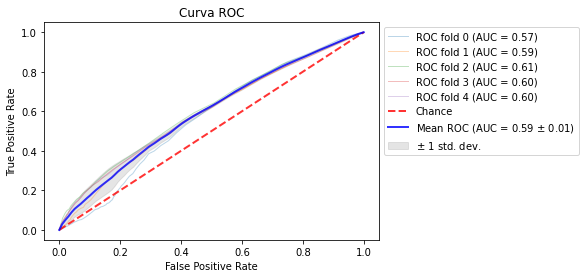

In [ ]:
metricas, matriz = StratifickfoldChiSquaredFeatures(X,y,random_forest_model,5)

In [ ]:
metricas

,Metricas_RF,Train,Test
0,metric_avg_acc_score,0.999925,0.879854
1,balanced_acc_score,0.999607,0.499751
2,recall_macro,0.999607,0.499751
3,presicion_macro,0.999940,0.584504
4,f1_score_macro,0.999774,0.482927
5,AUC_macro,1.000000,0.591418


In [ ]:
matriz

array([[11719.6,   434.2],
       [ 1172. ,    42.8]])

<center><h1> Reducción de Dimensionalidad PCA</h1></center>

Se aplicará PCA y LDA

In [ ]:
## dividimos el conjunto de datos 
X = df.drop(['OUTPUT_LABEL'],axis = 1)
y = df['OUTPUT_LABEL'].to_list()

In [ ]:
## Para aplicar PCA los datos deben estar estandarizado o escalos
# Escalamos los datos   
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)


In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=5)
pca.fit(X_scaled)
xx = pca.transform(X_scaled)

In [ ]:
xx.shape


(68357, 5)

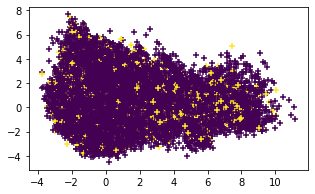

In [ ]:
plt.figure(figsize=(5,3))
plt.scatter(xx[:,0], xx[:,1], c=y, marker='+')
plt.show()

In [ ]:
X_pca = pd.DataFrame(data = xx)

In [ ]:
X_pca = X_pca.iloc[0:100,0:].reset_index(drop = True)

In [ ]:
X_pca

,0,1,2,3,4
0,-0.592640,-0.554429,0.766027,0.299744,-0.637349
1,0.287238,-0.677544,-0.839387,-0.273711,-0.169412
2,-0.326119,-0.398469,0.276381,0.082432,0.020455
3,-0.220826,-0.310719,-0.002208,0.149616,1.041838
4,0.159568,1.471080,-1.561845,-1.524928,-1.643997
...,...,...,...,...,...
95,-1.399078,-0.025688,2.082368,-1.478783,-0.669740
96,0.236535,-2.499657,0.061643,-1.871815,-0.699665
97,0.391079,0.901626,-1.441879,-1.411395,-0.458352
98,0.349336,1.241114,-1.831498,-0.936398,-0.881283


In [ ]:
y = pd.DataFrame(data = y).iloc[0:100,0].reset_index(drop = True)
y

0     0
1     0
2     0
3     0
4     0
     ..
95    0
96    0
97    0
98    0
99    0
Name: 0, Length: 100, dtype: int64

In [ ]:
y.value_counts()

0    92
1     8
Name: 0, dtype: int64

In [ ]:
# mount drive
#from google.colab import drive
#drive.mount('/content/gdrive')

In [ ]:
## Otra implementacion de validacion cruzada estratificada
from sklearn.model_selection import StratifiedKFold # validacion cruzada estratificada
#from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from google.colab import files

import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
def StratificPcaRoc(X,y,model,k):
  
  skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
  metrics = pd.DataFrame()
  # Creamos matriz vacia para guardar la matriz de confusion total
  matriz_confusion = np.zeros((2,2))
  acc_score = []
  balance_score = []
  recall_macro = []
  pres_recall_fs = []
  pres = []
  f_1score = []
  auc_roc = []
  ## variables para crear la curva ROC
  tprs = []
  aucs = []
  mean_fpr = np.linspace(0, 1, 100)
  fig, ax = plt.subplots()
  for i, (train, test) in enumerate(skf.split(X, y)):

      X_train = X.iloc[train]
      y_train = y.iloc[train]
      X_test = X.iloc[test]
      y_test = y.iloc[test]
      ## Balanceamos las clases del conjunto de  train, referencia --> https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/
      oversample = RandomOverSampler(sampling_strategy= 'minority')
      #fit y aplicamos la transformacion
      X_train, y_train = oversample.fit_resample(X_train, y_train)

      #y_train = pd.DataFrame(y_train)
      #print(y_train[0].value_counts())
      #print('*************')
      #X_train = pd.DataFrame(data = X_train)
      #print(X_train.shape)
      #print('****************************')


      # Entrenamiento
      model.fit(X_train, y_train)
      # Prediccion
      pred_values = model.predict(X_test)

      # Probabilidad de la prediccion
      pred_proba = model.predict_proba(X_test)

      ##Creamos matriz de confusión
      matrix = confusion_matrix(y_test, pred_values)
      #print(matrix)
      # sumamos la matriz de confusion
      matriz_confusion = matriz_confusion + matrix
      ## Calculo de metricas para cada fold

      # Accuracy metrica
      acc = accuracy_score(y_test, pred_values)
      acc_score.append(acc)

      # Balanced score
      bal_score = balanced_accuracy_score(y_test, pred_values)
      balance_score.append(bal_score)

      #recall macro
      recall = recall_score(y_test, pred_values, average='macro')
      recall_macro.append(recall)

      #precision, recall, fscore
      pres_rec_f = precision_recall_fscore_support(y_test, pred_values, average='macro')
      pres_recall_fs.append(pres_rec_f)

      #precision
      presci = precision_score(y_test, pred_values, average='macro')
      pres.append(presci)

      #f1_score
      f1score = f1_score(y_test, pred_values,average='macro')
      f_1score.append(f1score)

      # auc
      auc_metric = roc_auc_score(y_test, pred_values,average='macro')
      auc_roc.append(auc_metric)
      
      viz = plot_roc_curve(model, X_test, y_test,
                          name='ROC fold {}'.format(i),
                          alpha=0.3, lw=1, ax=ax)
      interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
      interp_tpr[0] = 0.0
      tprs.append(interp_tpr)
      aucs.append(viz.roc_auc)

  ## Armando el dataframe con metricas
  metrics['Model'] = ['Random Forest']
  metrics['metric_avg_acc_score'] = [sum(acc_score)/k]
  metrics['balanced_acc_score'] = [sum(balance_score)/k]
  metrics['recall_macro'] =  [sum(recall_macro)/k]
  metrics['presicion_macro'] = [sum(pres)/k]
  metrics['f1_score_macro'] = [sum(f_1score) / k]
  metrics['AUC'] = [sum(auc_roc) / k]


  ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
          label='Chance', alpha=.8)

  mean_tpr = np.mean(tprs, axis=0)
  mean_tpr[-1] = 1.0
  mean_auc = auc(mean_fpr, mean_tpr)
  std_auc = np.std(aucs)
  ax.plot(mean_fpr, mean_tpr, color='b',
          label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
          lw=2, alpha=.8)

  std_tpr = np.std(tprs, axis=0)
  tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
  tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
  ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                  label=r'$\pm$ 1 std. dev.')

  ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
        title="Curva ROC")
  ax.legend(loc="upper left", bbox_to_anchor=(1,1))
  #plt.savefig('/content/gdrive/MyDrive/001_Diplomado Ciencia de datos Avanzado/Proyecto_1/',bbox_inches='tight', dpi = 1500)
  plt.show()

  return metrics , matriz_confusion/k

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

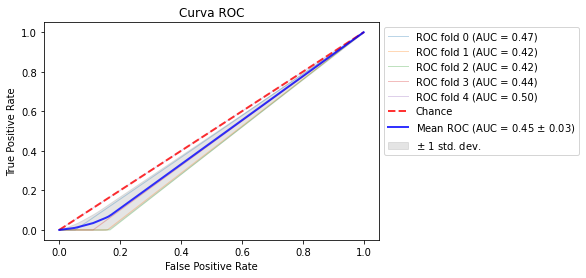

In [ ]:
from sklearn.ensemble import RandomForestClassifier #Random forest
metrics, mc = StratificPcaRoc(X_pca,y, RandomForestClassifier(n_estimators=1, random_state=0) , 5)

In [ ]:
metrics

,Model,metric_avg_acc_score,balanced_acc_score,recall_macro,presicion_macro,f1_score_macro,AUC
0,Random Forest,0.83,0.45117,0.45117,0.455979,0.452966,0.45117


# <center><h1>Reduccion de Dimensionalidad LDA</h1></center>

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [ ]:
lda = LinearDiscriminantAnalysis(n_components=2)
lda = lda.fit(X_scaled, y)
X_r2 = lda.transform(X_scaled)
np.unique(y)

/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:463: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(74, 2 - 1) = 1 components.
  ChangedBehaviorWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:469: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)


array([0, 1])

In [ ]:
X_r2.shape

(66843, 1)

In [ ]:
colors = ['navy', 'turquoise']

plt.figure()
for color, i, target_name in zip(colors, [1, 2], ['clase 1', 'clase 2']):
    plt.scatter(X_r2[y == i][:, 0], X_r2[y == i][:, 1], alpha=.8, color=color,
                label=target_name, s=10)
    
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('Reduccion LDA')

plt.legend(bbox_to_anchor=(1.3, 1.05))
plt.show()

TypeError: ignored

<Figure size 432x288 with 0 Axes>

In [ ]:
X_r2

array([[-0.45434152],
       [ 0.12308009],
       [-0.56827499],
       ...,
       [ 0.16376414],
       [-0.22639475],
       [-0.66462956]])

In [ ]:
#### Pruebas,  seleccionando un dataframe mas pequeño
muestras_positivas = df.OUTPUT_LABEL == 1
positivas = df.loc[muestras_positivas].iloc[0:60].reset_index(drop = True)
negativas = df.loc[~muestras_positivas].iloc[0:600].reset_index(drop = True)
df = pd.concat([positivas, negativas], axis = 0).reset_index(drop = True)

In [ ]:
## dividimos el conjunto de datos 
X = df.drop(['OUTPUT_LABEL'],axis = 1)
y = df['OUTPUT_LABEL']

In [ ]:
#y = pd.DataFrame(data = y.values.reshape(660,1))

In [ ]:
#type(y)

In [ ]:
## Dividimos los datos en train (70%) y test (30%)
#from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
#print(y_train.value_counts())

In [ ]:
#desbalance en el conjunto de train
# plot the distribution
#plt.bar(y_train.unique(), y_train.value_counts())
#plt.show()

In [ ]:
## Instalando libreria 
#!pip install imbalanced-learn

In [ ]:
## dividimos el conjunto de datos 
#X = df.drop(['OUTPUT_LABEL'],axis = 1)
#y = df['OUTPUT_LABEL']

In [ ]:
#y = pd.DataFrame(data = y)
#y.head()

In [ ]:
#Importamos Librerias
from sklearn.ensemble import RandomForestClassifier #Random forest
#confusion, accuracy  = Only_Stratified_Kfold(X,y, RandomForestClassifier(n_estimators=200, random_state=0))
## dividimos el conjunto de datos 
X = df.drop(['OUTPUT_LABEL'],axis = 1)
y = df['OUTPUT_LABEL']

In [ ]:
## Otra implementacion de validacion cruzada estratificada
def cross_validation_stratific(X,y,model,k):
  from sklearn.model_selection import StratifiedKFold # validacion cruzada estratificada
  from sklearn.preprocessing import StandardScaler
  from sklearn.metrics import accuracy_score
  from sklearn.metrics import confusion_matrix
  from imblearn.over_sampling import RandomOverSampler
  from sklearn.metrics import balanced_accuracy_score
  from sklearn.metrics import recall_score
  from sklearn.metrics import precision_recall_fscore_support
  from sklearn.metrics import precision_score
  from sklearn.metrics import f1_score
  from sklearn.metrics import roc_auc_score
  #Configurando la Validacion cruzada estratificada
  skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

# Creamos matriz vacia para guardar la matriz de confusion total
  matriz_confusion = np.zeros((2,2))
  acc_score = []
  balance_score = []
  recall_macro = []
  pres_recall_fs = []
  pres = []
  f_1score = []
  auc_roc = []
  for train_index , test_index in skf.split(X,y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index] , y.iloc[test_index]

    ## Balanceamos las clases del conjunto de  train, referencia --> https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/
    oversample = RandomOverSampler(sampling_strategy= 'minority')
    #fit y aplicamos la transformacion
    X_train, y_train = oversample.fit_resample(X_train, y_train)
    #print('tipe y_test: ',type(y_test))

    #print(pd.DataFrame(y_train).value_counts())
    # Escalamos los datos   
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)


    model.fit(X_train,y_train)
    pred_values = model.predict(X_test)

    ##Creamos matriz de confusión
    matrix = confusion_matrix(y_test, pred_values)
    #print(matrix)
    # sumamos la matriz de confusion
    matriz_confusion = matriz_confusion + matrix

    # Accuracy metrica
    acc = accuracy_score(y_test, pred_values)
    acc_score.append(acc)

    # Balanced score
    bal_score = balanced_accuracy_score(y_test, pred_values)
    balance_score.append(bal_score)

    #recall macro
    recall = recall_score(y_test, pred_values, average='macro')
    recall_macro.append(recall)

    #precision, recall, fscore
    pres_rec_f = precision_recall_fscore_support(y_test, pred_values, average='macro')
    pres_recall_fs.append(pres_rec_f)

    #precision
    presci = precision_score(y_test, pred_values, average='macro')
    pres.append(presci)

    #f1_score
    f1score = f1_score(y_test, pred_values,average='macro')
    f_1score.append(f1score)


    # auc
    auc_metric = roc_auc_score(y_test, pred_values,average='macro')
    auc_roc.append(auc_metric)

  metrics['Model'] = ['Random Forest']
  metrics['metric_avg_acc_score'] = [sum(acc_score)/k]
  metrics['balanced_acc_score'] = [sum(balance_score)/k]
  metrics['recall_macro'] =  [sum(recall_macro)/k]
  metrics['presicion_macro'] = [sum(pres)/k]
  metrics['f1_score_macro'] = [sum(f_1score) / k]
  metrics['AUC'] = [sum(auc_roc) / k]

  #return avg_acc_score, matriz_confusion , balanced_acc_score, recall_macro, pres_recall_fs, presicion_macro, f1_score_macro
  return metrics


In [ ]:
#Importamos Librerias
from sklearn.ensemble import RandomForestClassifier #Random forest
metrics = cross_validation_stratific(X,y,RandomForestClassifier(n_estimators=200, random_state=0),10)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

In [ ]:
metrics

,Model,metric_avg_acc_score,balanced_acc_score,recall_macro,presicion_macro,f1_score_macro,AUC
0,Random Forest,0.907664,0.508233,0.508233,0.634178,0.494745,0.508233


In [ ]:
recall_macro

0.4966666666666667

In [ ]:
pres_rec_fs

[(0.45454545454545453, 0.5, 0.47619047619047616, None),
 (0.45384615384615384, 0.49166666666666664, 0.472, None),
 (0.45454545454545453, 0.5, 0.47619047619047616, None),
 (0.45454545454545453, 0.5, 0.47619047619047616, None),
 (0.45454545454545453, 0.5, 0.47619047619047616, None),
 (0.45454545454545453, 0.5, 0.47619047619047616, None),
 (0.4523809523809524, 0.475, 0.46341463414634143, None),
 (0.45454545454545453, 0.5, 0.47619047619047616, None),
 (0.45454545454545453, 0.5, 0.47619047619047616, None),
 (0.45454545454545453, 0.5, 0.47619047619047616, None)]

In [ ]:
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold # validacion cruzada estratificada
 

 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
 

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Random Forest 
from sklearn.ensemble import RandomForestClassifier #Random forest

cld_rf = RandomForestClassifier(n_estimators=200, random_state=0)

 
cld_rf.fit(X_train, y_train)
 
score = cld_rf.score(X_train,y_train)
 
print("Metrica del modelo", score)
 
scores = cross_val_score(cld_rf, X_train, y_train, cv=skf, scoring="accuracy")
 
print("Metricas cross_validation", scores)
 
print("Media de cross_validation", scores.mean())
 
preds = cld_rf.predict(X_test)
 
score_pred = metrics.accuracy_score(y_test, preds)
 
print("Metrica en Test", score_pred)

Metrica del modelo 1.0


KeyboardInterrupt: ignored

In [ ]:
y_train.value_counts()

0    422
1     40
Name: OUTPUT_LABEL, dtype: int64

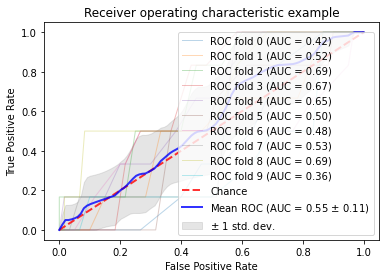

In [ ]:
# Curva ROC

import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import StratifiedKFold

# #############################################################################
# Data IO and generation

# Import some data to play with
## dividimos el conjunto de datos 
X = df.drop(['OUTPUT_LABEL'],axis = 1)
y = df['OUTPUT_LABEL']
#X, y = X[y != 2], y[y != 2]
n_samples, n_features = X.shape

# Add noisy features
random_state = np.random.RandomState(0)
X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]

# #############################################################################
# Classification and ROC analysis

# Run classifier with cross-validation and plot ROC curves
#cv = StratifiedKFold(n_splits=6)
  
#Configurando la Validacion cruzada estratificada
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
classifier = RandomForestClassifier(n_estimators=200, random_state=0)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
for i, (train, test) in enumerate(cv.split(X, y)):
    classifier.fit(X[train], y[train])
    viz = plot_roc_curve(classifier, X[test], y[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mxean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic example")
ax.legend(loc="lower right")
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: DeprecationWarning: scipy.interp is deprecated and will be removed in 

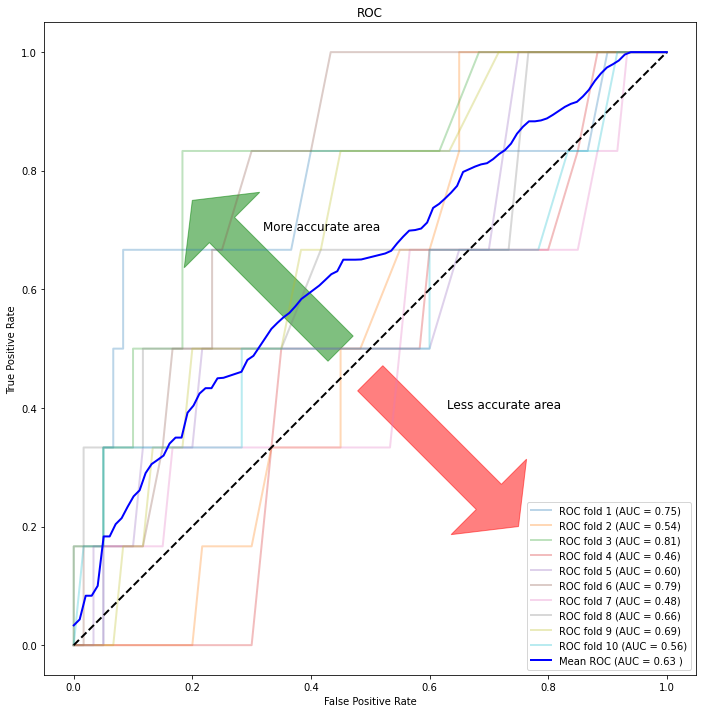

In [ ]:
import matplotlib.patches as patches
from sklearn.metrics import roc_curve,auc
from scipy import interp

x = df.drop(['OUTPUT_LABEL'],axis = 1)
y = df['OUTPUT_LABEL']

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
clf = RandomForestClassifier(n_estimators=200, random_state=0)
# plot arrows
fig1 = plt.figure(figsize=[12,12])
ax1 = fig1.add_subplot(111,aspect = 'equal')
ax1.add_patch(
    patches.Arrow(0.45,0.5,-0.25,0.25,width=0.3,color='green',alpha = 0.5)
    )
ax1.add_patch(
    patches.Arrow(0.5,0.45,0.25,-0.25,width=0.3,color='red',alpha = 0.5)
    )

tprs = []
aucs = []
mean_fpr = np.linspace(0,1,100)
i = 1
for train,test in cv.split(x,y):
    prediction = clf.fit(x.iloc[train],y.iloc[train]).predict_proba(x.iloc[test])
    fpr, tpr, t = roc_curve(y[test], prediction[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i= i+1

plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='blue',
         label=r'Mean ROC (AUC = %0.2f )' % (mean_auc),lw=2, alpha=1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.text(0.32,0.7,'More accurate area',fontsize = 12)
plt.text(0.63,0.4,'Less accurate area',fontsize = 12)
plt.show()

In [ ]:
import numpy as np
from sklearn.model_selection import StratifiedKFold # validacion cruzada estratificada
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

#Configurando la Validacion cruzada estratificada
skf = StratifiedKFold(n_splits=10, shuffle= True, random_state= 42)

# Random Forest 
from sklearn.ensemble import RandomForestClassifier #Random forest

cld_rf = RandomForestClassifier(n_estimators=200, random_state=0)

## Probando con el modelo

for train_index , test_index in skf.split(X,y):
  X_train, X_test = X.iloc[train_index], X.iloc[test_index]
  y_train, y_test = y.iloc[train_index], y.iloc[test_index]

  ## Balanceo de la clase de entrenamiento usando oversampling




  # Escalamos los datos
  scaler = StandardScaler()
  scaler.fit(X_train)
  X_train = scaler.transform(X_train)
  X_test = scaler.transform(X_test)

  # Entrenamos el modelo
  cld_rf.fit(X_train, y_train)

  #Predicciones
  #train_pred = cld_rf.predict(X_train)
  pred = cld_rf.predict(X_test)

  # Probabilidad para la fila

  prob = cld_rf.predict_proba(X_test)


## Con selec k-best veremos cuales son los atributos que más poder predictivo tienen

In [ ]:
## Métodos de Filtro
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# Extracción de Carácterísticas: chi-cuadrado
prueba = SelectKBest(score_func = chi2, k=5)
entrenamiento = prueba.fit(X,y)

scores = pd.DataFrame(data = list(zip(X.columns, entrenamiento.scores_)), columns = ['Atributo','Scores']).sort_values(by='Scores', ascending = False)
scores

,Atributo,Scores
7,number_inpatient,4101.916342
2,num_lab_procedures,4082.085533
36,discharge_disposition_id_22,1824.609880
4,num_medications,1694.227648
1,time_in_hospital,1560.940693
...,...,...
17,admission_type_id_4,1.864267
60,max_glu_serum_Norm,1.018833
59,max_glu_serum_None,0.736664
28,discharge_disposition_id_8,0.010946


In [ ]:
# Estandarizamos la data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(X)

## Dividimos los datos en train (70%) y test (30%)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#Importamos Librerias
from sklearn.naive_bayes import GaussianNB ## Naive bayes
from sklearn.neighbors import KNeighborsClassifier ## KNN
from sklearn import svm  # Support Vector Machine
from sklearn.ensemble import RandomForestClassifier #Random forest
from sklearn.tree import DecisionTreeClassifier, export_graphviz ## Arboles de descision 

## Naive Bayes
clf_gnb = GaussianNB()
## Entrenamiento
clf_gnb = clf_gnb.fit(X_train, y_train)
## Prediccion
y_hat_gnb = clf_gnb.predict(X_test)

## KNN
clf_knn = KNeighborsClassifier(n_neighbors=100)
## Entrenamiento
clf_knn = clf_knn.fit(X_train, y_train)
## Prediccion
y_hat_knn = clf_knn.predict(X_test)

## SVM
clf_svm = svm.SVC(kernel='rbf') 
clf_svm = clf_svm.fit(X_train, y_train)
y_hat_svm = clf_svm.predict(X_test)

# Decision Tree Classifier
clf_dt = DecisionTreeClassifier()
clf_dt = clf_dt.fit(X_train,y_train)
y_hat_dt = clf_dt.predict(X_test)

## Random Forest
cld_rf = RandomForestClassifier(n_estimators=200, random_state=0)
cld_rf = cld_rf.fit(X_train,y_train)
y_hat_rf = cld_rf.predict(X_test)


from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score


metrics = pd.DataFrame()

acc_list = []
bacc_list = []
pre_list = []
reca_list = []
f1_list = []
for pred in [y_hat_gnb, y_hat_knn, y_hat_svm, y_hat_dt, y_hat_rf]:
    acc_list.append(accuracy_score(y_test, pred))
    bacc_list.append(balanced_accuracy_score(y_test, pred))
    pre_list.append(precision_score(y_test, pred, average='macro'))
    reca_list.append(recall_score(y_test, pred, average='macro'))
    f1_list.append(f1_score(y_test, pred, average='macro'))

models = ['Gaussian Naive Bayes', "kNN", "SVM", "Decision Tree", "Random Forest"]

metrics['Model'] = models
metrics['ACC'] = acc_list
metrics['BACC'] = bacc_list
metrics['Precision'] = pre_list
metrics['Recall'] = reca_list
metrics['F1'] = f1_list

metrics.sort_values('F1', ascending=False)

/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


,Model,ACC,BACC,Precision,Recall,F1
4,Random Forest,0.693466,0.692599,0.694771,0.692599,0.677544
2,SVM,0.605764,0.604581,0.609522,0.604581,0.595892
3,Decision Tree,0.593449,0.593356,0.591566,0.593356,0.592342
1,kNN,0.528649,0.528204,0.525835,0.528204,0.525196
0,Gaussian Naive Bayes,0.336004,0.337852,0.442278,0.337852,0.183158
